In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")   

---
### Произведем объединение первичных данных

In [2]:
# Загрузка данных
def load_data():
    customers = pd.read_csv("./clean_data/customers.csv")
    geolocation = pd.read_csv("./clean_data/geolocation.csv")
    order_pay = pd.read_csv("./clean_data/order_payments.csv")
    reviews = pd.read_csv("./clean_data/order_reviews.csv")
    orders = pd.read_csv("./clean_data/orders.csv")
    item = pd.read_csv("./clean_data/orders_items.csv")
    category_name = pd.read_csv(
        "./clean_data/product_category_name_translation.csv")
    products = pd.read_csv("./clean_data/products.csv")
    sellers = pd.read_csv("./clean_data/sellers.csv")
    return customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers


In [3]:
# Объединение данных
def merge_data(orders, item, order_pay, reviews, products, customers, sellers, category_name):
    df = orders.merge(item, on='order_id', how='left')
    df = df.merge(order_pay, on='order_id', how='outer', validate='m:m')
    df = df.merge(reviews, on='order_id', how='outer')
    df = df.merge(products, on='product_id', how='outer')
    df = df.merge(customers, on='customer_id', how='outer')
    df = df.merge(sellers, on='seller_id', how='outer')
    df = df.merge(category_name, on="product_category_name", how="left")
    return df

In [4]:
# Очистка данных: удаление строк без customer_unique_id
def filter_customers(df):
    return df[~df["customer_unique_id"].isna()]

In [5]:
# Главная функция пайплайна
def main_pipeline():
    # Шаг 1: Загрузка данных
    customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers = load_data()

    # Шаг 2: Объединение данных
    df = merge_data(orders, item, order_pay, reviews, products,
                    customers, sellers, category_name)

    # Шаг 3: Фильтрация данных
    df = filter_customers(df)

    final_data = df

    return final_data

In [6]:
data = main_pipeline()

In [10]:
labels = pd.read_csv("./labels/combo_clust.csv")
labels.head()

,customer_unique_id,labels_final,labels_decode
0,0000366f3b9a7992bf8c76cfdf3221e2,2,Потенциально лояльные
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,Потенциально лояльные
2,0000f46a3911fa3c0805444483337064,0,Разовый клиент
3,0000f6ccb0745a6a4b88665a16c9f078,0,Разовый клиент
4,0004aac84e0df4da2b147fca70cf8255,0,Разовый клиент


In [11]:
labels = labels[["customer_unique_id", "labels_final"]]
labels.head()

,customer_unique_id,labels_final
0,0000366f3b9a7992bf8c76cfdf3221e2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2
2,0000f46a3911fa3c0805444483337064,0
3,0000f6ccb0745a6a4b88665a16c9f078,0
4,0004aac84e0df4da2b147fca70cf8255,0


---
### Сформируем портрет клиента на основе подхода который мы использовали для KMeans, но с учетом тех фитов которые мы можем поймать даже при первой покупке клиента, т.е. группа товаров, город, цена товара, оценка товара, что-то, что позволит нам идентифицировать клиента гораздо заранее с определенной долей вероятности

In [12]:
# Сформируем информацию по количеству покупок
orderer_by_client = data.groupby(["customer_unique_id",])[
    ["order_id"]].count().reset_index().rename(columns={"order_id":"num_orders"})

orderer_by_client

,customer_unique_id,num_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2
96092,fffea47cd6d3cc0a88bd621562a9d061,1
96093,ffff371b4d645b6ecea244b27531430a,1
96094,ffff5962728ec6157033ef9805bacc48,1


In [13]:
clients_city = data[["customer_unique_id", "customer_city"]]
clients_city = clients_city.drop_duplicates()
clients_city

,customer_unique_id,customer_city
0,3c7e305796add66698959fc7ad176f6b,umuarama
1,9de5797cddb92598755a0f76383ddbbb,entre rios de minas
2,9915eb9f74b6c11aaf04833f65b00e93,paracatu
3,dce323533e45e74d215e0fe7fb114118,sao goncalo
5,acfca8c3549ceceba9e125afc0349610,curitiba
...,...,...
118805,1479d41bbd302e37d1316c996c1f55ae,uberlandia
118806,587b326ba3bf8aa4d3e50fb1f38ea79f,cotia
118808,1942b890cee1b55dbf8176e925e79e07,porto alegre
118809,0f21adf44f13a61282678a89f6433c10,salvador


In [14]:
payments_ratings = data.groupby("customer_unique_id")[
    ["payment_value", "payment_installments", "price", "review_score"]].agg(["mean"]).reset_index()
payments_ratings.columns = ['_'.join(col).strip('_') for col in payments_ratings.columns.values]
payments_ratings

,customer_unique_id,payment_value_mean,payment_installments_mean,price_mean,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,8.0,129.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1.0,18.90,4.0
2,0000f46a3911fa3c0805444483337064,86.22,8.0,69.00,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,4.0,25.99,4.0
4,0004aac84e0df4da2b147fca70cf8255,196.89,6.0,180.00,5.0
...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,10.0,785.00,5.0
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1.0,64.89,4.0
96093,ffff371b4d645b6ecea244b27531430a,112.46,1.0,89.90,5.0
96094,ffff5962728ec6157033ef9805bacc48,133.69,5.0,115.00,5.0


In [15]:
# Сформируем информацию по модальной категории продуктов в разрезе пользователей
def calculate_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

mode_category = (
    data.groupby("customer_unique_id")["product_category_name_english"]
    .agg(calculate_mode)
    .reset_index()
)

mode_category.columns = ["customer_unique_id", "most_frequent_product_category"]

mode_category


,customer_unique_id,most_frequent_product_category
0,0000366f3b9a7992bf8c76cfdf3221e2,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty
2,0000f46a3911fa3c0805444483337064,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,telephony
4,0004aac84e0df4da2b147fca70cf8255,telephony
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,health_beauty
96092,fffea47cd6d3cc0a88bd621562a9d061,baby
96093,ffff371b4d645b6ecea244b27531430a,auto
96094,ffff5962728ec6157033ef9805bacc48,watches_gifts


In [16]:
clients_data_1 = orderer_by_client.merge(
    payments_ratings, on="customer_unique_id")
clients_data_2 = clients_city.merge(mode_category, on="customer_unique_id")
clients_data = clients_data_1.merge(
    clients_data_2, on="customer_unique_id")

# ОбЪединяем с лейблами
clients_data_labeled = labels.merge(clients_data, on="customer_unique_id")
clients_data_labeled.head()

,customer_unique_id,labels_final,num_orders,payment_value_mean,payment_installments_mean,price_mean,review_score_mean,customer_city,most_frequent_product_category
0,0000366f3b9a7992bf8c76cfdf3221e2,2,1,141.90,8.0,129.90,5.0,cajamar,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,1,27.19,1.0,18.90,4.0,osasco,health_beauty
2,0000f46a3911fa3c0805444483337064,0,1,86.22,8.0,69.00,3.0,sao jose,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,0,1,43.62,4.0,25.99,4.0,belem,telephony
4,0004aac84e0df4da2b147fca70cf8255,0,1,196.89,6.0,180.00,5.0,sorocaba,telephony


In [18]:
# Кодируем и центрируем что нужно
label_encoder_city = LabelEncoder()
label_encoder_cat = LabelEncoder()
scaler = StandardScaler()

num_columns = ["num_orders", "payment_value_mean", "payment_installments_mean",
               "price_mean", "review_score_mean"]
cat_columns = ["customer_city", "most_frequent_product_category"]


# Разделение на X и y
X = clients_data_labeled[num_columns + cat_columns]
y = clients_data_labeled["labels_final"]

X_scaled = scaler.fit_transform(X[num_columns])
X_city = label_encoder_city.fit_transform(X["customer_city"])
X_category = label_encoder_cat.fit_transform(
    X["most_frequent_product_category"])

X_joined = pd.concat([pd.DataFrame(X_scaled, columns=num_columns), pd.DataFrame(
    X_city, columns=["customer_city"]), pd.DataFrame(X_category, columns=["most_frequent_product_category"])], axis=1)
X_joined

,num_orders,payment_value_mean,payment_installments_mean,price_mean,review_score_mean,customer_city,most_frequent_product_category
0,-0.286398,-0.073225,1.902008,0.022674,0.661200,647,7
1,-0.286398,-0.605848,-0.711179,-0.566569,-0.120986,2564,43
2,-0.286398,-0.331760,1.902008,-0.300613,-0.903172,3477,66
3,-0.286398,-0.529560,0.408758,-0.528932,-0.120986,443,68
4,-0.286398,0.182105,1.155383,0.288629,0.661200,3713,68
...,...,...,...,...,...,...,...
91807,0.880857,8.867378,2.648632,3.500267,0.661200,3217,43
91808,-0.286398,-0.339374,-0.711179,-0.322431,-0.120986,1311,6
91809,-0.286398,-0.209922,-0.711179,-0.189666,0.661200,3695,5
91810,-0.286398,-0.111346,0.782071,-0.056423,0.661200,511,70


In [19]:
y.value_counts()

labels_final
2    45494
0    38420
1     7898
Name: count, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_joined, y, test_size=0.2, stratify=y, random_state=42)

---
### Пробуем лес как базу

In [21]:
rf_classif = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_classif.fit(X_train, y_train)

y_pred = rf_classif.predict(X_test)
y_test_pred = rf_classif.predict(X_train)

In [22]:
accuracy_score(y_test, y_pred)

0.6546315961444208

In [23]:
accuracy_score(y_train, y_test_pred)

0.9976173943824967

> Лес переобучился

---
### Пробуем xgboost

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_joined, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
# Импортируем необходимые библиотеки
import xgboost as xgb
from sklearn.metrics import accuracy_score


# Преобразуем данные в формат DMatrix, который используется в XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Параметры модели
params = {
    'objective': 'multi:softmax',  # Целевая функция для многоклассовой классификации
    'num_class': 3,               # Количество классов
    'max_depth': 3,               # Максимальная глубина деревьев
    'eta': 0.01,                   # Скорость обучения (learning rate)
    'subsample': 0.7,             # Доля выборки, используемая для обучения каждого дерева
    'colsample_bytree': 0.5      # Доля признаков, используемых для обучения каждого дерева
}

# Обучение модели
num_rounds = 1000  # Количество итераций (деревьев)
model = xgb.train(params, dtrain, num_rounds)

# Предсказание на тестовых данных
y_pred = model.predict(dtest)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.59


---

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_joined, y, test_size=0.2, stratify=y, random_state=42)

In [37]:
y_weights = y.value_counts().to_dict()

Using device: mps
Epoch [1/50], Loss: 1.1435
Epoch [2/50], Loss: 1.0297
Epoch [3/50], Loss: 1.1143
Epoch [4/50], Loss: 1.1448
Epoch [5/50], Loss: 1.1094
Epoch [6/50], Loss: 1.0270
Epoch [7/50], Loss: 1.1421
Epoch [8/50], Loss: 1.1299
Epoch [9/50], Loss: 1.1090
Epoch [10/50], Loss: 1.0575
Epoch [11/50], Loss: 1.1429
Epoch [12/50], Loss: 1.1063
Epoch [13/50], Loss: 1.0752
Epoch [14/50], Loss: 1.1872
Epoch [15/50], Loss: 1.1546
Epoch [16/50], Loss: 1.1567
Epoch [17/50], Loss: 1.1084
Epoch [18/50], Loss: 1.1622
Epoch [19/50], Loss: 1.0119
Epoch [20/50], Loss: 1.0689
Epoch [21/50], Loss: 1.1804
Epoch [22/50], Loss: 1.1619
Epoch [23/50], Loss: 1.1358
Epoch [24/50], Loss: 1.2087
Epoch [25/50], Loss: 1.1127
Epoch [26/50], Loss: 1.0600
Epoch [27/50], Loss: 0.9759
Epoch [28/50], Loss: 1.0245
Epoch [29/50], Loss: 1.0423
Epoch [30/50], Loss: 1.1674
Epoch [31/50], Loss: 1.0352
Epoch [32/50], Loss: 1.1520
Epoch [33/50], Loss: 1.1411
Epoch [34/50], Loss: 1.1193
Epoch [35/50], Loss: 1.0400
Epoch [36/5

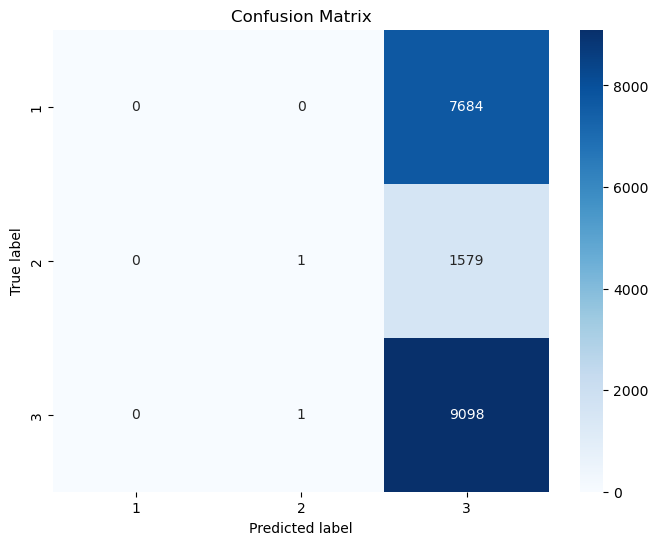

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00      7684
     Class 2       0.50      0.00      0.00      1580
     Class 3       0.50      1.00      0.66      9099

    accuracy                           0.50     18363
   macro avg       0.33      0.33      0.22     18363
weighted avg       0.29      0.50      0.33     18363



In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Определение архитектуры нейронной сети
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
# 2. Подготовка данных
input_size = X_joined.shape[1]  # Размер входных данных
hidden_size = 32  # Увеличили число нейронов
num_classes = 3  # Количество классов для классификации

# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values).long()

# Создание Dataset и DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# 3. Перевод модели и данных на устройство
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleClassifier(input_size, hidden_size, num_classes).to(device)

# Инициализация функции потерь и оптимизатора
class_counts = [y_weights[0], y_weights[1], y_weights[2]]
total_samples = sum(class_counts)
weights = torch.tensor([total_samples / count for count in class_counts])
weights = weights / weights.sum()
weights = weights.to(device)

loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Прямой проход
        pred = model(batch_X)
        loss = loss_fn(pred, batch_y)

        # Backward pass и оптимизация
        optimizer.zero_grad()  # Обнуление градиентов
        loss.backward()  # Вычисление градиентов
        optimizer.step()  # Обновление весов

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# 4. Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)  # Предполагаем, что X_test уже определён
y_test_tensor = torch.tensor(y_test.values).long().to(device)  # Предполагаем, что y_test уже определён

# Переключаем модель в режим оценки
model.eval()

# Отключаем вычисление градиентов во время тестирования
with torch.no_grad():
    # Получаем предсказания
    predictions = model(X_test_tensor)
    _, predicted_classes = torch.max(predictions, 1)

# Рассчитываем точность
accuracy = (predicted_classes == y_test_tensor).float().mean().item()
print(f'Accuracy: {accuracy:.4f}')

# Матрица путаницы и отчет о классификации
conf_matrix = confusion_matrix(y_test_tensor.cpu(), predicted_classes.cpu())
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_tensor.cpu(), predicted_classes.cpu(), target_names=['Class 1', 'Class 2', 'Class 3']))

In [40]:
print("Предсказанные классы:", predicted_classes.cpu().numpy())

Предсказанные классы: [2 2 2 ... 2 2 2]


In [41]:
print(y_train.value_counts())
print(y_test.value_counts())

labels_final
2    36395
0    30736
1     6318
Name: count, dtype: int64
labels_final
2    9099
0    7684
1    1580
Name: count, dtype: int64


In [119]:
# Сохранение модели
torch.save(model.state_dict(), "../services/model_classif.pth")
print("Модель успешно сохранена.")

Модель успешно сохранена.


In [120]:
# Загрузка модели
model = SimpleClassifier(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load("../services/model_classif.pth"))
print("Модель успешно загружена.")

Модель успешно загружена.


In [42]:
# Подготовка тестовых данных
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Предсказание
model.eval()  # Убедитесь, что модель находится в режиме оценки
with torch.no_grad():  # Отключаем вычисление градиентов
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)  # Получаем индексы максимальных значений (классы)

print("Предсказанные классы:", predicted.cpu().numpy())

Предсказанные классы: [2 2 2 ... 2 2 2]


In [43]:
# Истинные метки
y_test_tensor = torch.tensor(y_test.values).long()

# Оценка точности
accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy())
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4955


In [138]:
pd.Series(predicted.cpu().numpy()).value_counts()

2    17320
Name: count, dtype: int64